Script for running a simple quantile mapping method via the xsbda python package  
Written for the SD-Ocean Line P Hackathon in December 2025

@author Hayley Dosser  
October 2025

### Quantile Mapping using XSDBA

Code based on https://xsdba.readthedocs.io/en/latest/notebooks/example.html and applied to a subset of the Line P CTD data and NEP36 model output (https://hpfx.collab.science.gc.ca/dfo/SD-Ocean/Training/models/NEP36-CanOE/)

xsdba algorithms require a reference time series (ref), historical simulations (hist), and simulations to be adjusted (sim). The method is used to estimate the adjustment factors between the historical simulations and the reference time series, then these factors are applied to the simulations to be adjusted.

### Simple example using T, S, or O2 from 1996 to 2020 in a 5m depth-range spanning 5 Line P stations
In this case, for temperature, salinity, and oxygen,
    ref = Line P CTD data for 1996 to 2020 for 5 Line P Stations (e.g., P4 to P8) spanning a 5m depth-range (e.g., 0 to 5m)  
    hist = NEP36 model output for 1996 to 2020 for those same 5 Line P Stations over the same 5m depth-range, subset to match the DFO data  
    sim = NEP36 model output for 1996 to 2020 for the 5 Stations over the 5m depth-range for all months, depths, etc. with missing DFO data 

The steps to be applied are as follows: 
1. Extract ref from the Line P CTD data files
2. Interpolate ref to a 1m vertical grid, interpolate over any NaNs
3. Extract data from the NEP36 model output files
4. Interpolate the NEP36 data to the vertical levels used by ref
5. Extract hist and sim from the NEP36 data and and train the QM model
6. Validate the algorithm
7. Apply the algorithm to adjust sim

In [1]:
import gsw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xsdba

### Specify the depths, Stations, and variables of interest
In the final script, all depths and Stations will be included. A subset is used here to speed up running the model and allow for experimentation. The biogeochemical variables may require some modifications to the code. Some QM algorithms also exist that can be applied to multiple variables simultaneously, retaining relationships between variables. 

In [2]:
# Depths and stations and variable and years of interest
ctd_path = '/Users/ashao/data/linep/lineP_CTD_training.csv'
nep36_path = '/Users/ashao/data/linep/NEP36_along_LineP.nc'
depths_oi = [101.5,102.5,103.5,104.5,105.5]
stations_oi = ['P4','P5','P6','P7','P8']
vars_oi = {'var':'POTENTIAL_TEMPERATURE', 'units':'degC'} # The variable names for both DFO and the model data must match this!
years_oi = np.arange(1996,2021,1)

# Number of quantiles to use for the Quantile Mapping
nq = 10

### Step 1: Extract ref from the Line P CTD data files 

In [3]:
# Load the Line P CTD data
df_temp = pd.read_csv(ctd_path,delimiter=',',comment='#')
df_temp

,STATION_ID,TIME,LATITUDE,LONGITUDE,DEPTH,PRESSURE,PRESSURE_BIN_CENTER,TEMPERATURE,SALINITY,OXYGEN_MMOL_M3,OXYGEN_UMOL_KG
0,P26,1969-08-26 22:18:00,50.000000,-145.00000,0.000000,0.000000,0.5,12.3000,32.5200,NaN,NaN
1,P26,1969-08-26 22:18:00,50.000000,-145.00000,5.000000,5.043289,5.5,12.1500,32.5200,NaN,NaN
2,P26,1969-08-26 22:18:00,50.000000,-145.00000,10.000000,10.086701,10.5,12.1200,32.5200,NaN,NaN
3,P26,1969-08-26 22:18:00,50.000000,-145.00000,32.000000,32.279182,32.5,8.5000,32.5200,NaN,NaN
4,P26,1969-08-26 22:18:00,50.000000,-145.00000,35.000000,35.305614,35.5,7.8000,32.5400,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
5233798,P17,2020-02-13 12:39:40,49.350166,-135.66684,1974.521684,2001.000000,2001.5,1.9819,34.5800,53.52,52.0
5233799,P17,2020-02-13 12:39:40,49.350166,-135.66684,1975.503826,2002.000000,2002.5,1.9802,34.5804,53.52,52.0
5233800,P17,2020-02-13 12:39:40,49.350166,-135.66684,1976.485963,2003.000000,2003.5,1.9801,34.5804,53.52,52.0
5233801,P17,2020-02-13 12:39:40,49.350166,-135.66684,1977.468096,2004.000000,2004.5,1.9800,34.5805,53.52,52.0


In [4]:
# Extract the subset we want, and move it into a dataframe

# Keep the stations we want
keep_condition = np.any([df_temp['STATION_ID']==x for x in stations_oi],axis=0)
df_temp = df_temp.drop(df_temp[~keep_condition].index)

# Keep only the depths we want(assume depth is close enough to pressure for our purposes here)
keep_condition = np.any([df_temp['PRESSURE_BIN_CENTER']==x for x in depths_oi],axis=0)
df_temp = df_temp.drop(df_temp[~keep_condition].index)

# Move the date into a format we can work with
df_temp['TIME'] = pd.to_datetime(df_temp['TIME'])

# Keep only the years we want
keep_condition = np.any([df_temp['TIME'].dt.year==x for x in years_oi],axis=0)
df_temp = df_temp.drop(df_temp[~keep_condition].index)

# Calculate potential temperature since this is what is used by the model
fld = gsw.pt_from_t(gsw.SA_from_SP(df_temp.SALINITY,df_temp.PRESSURE,df_temp.LONGITUDE,df_temp.LATITUDE),df_temp.TEMPERATURE,df_temp.PRESSURE,0)
df_temp['POTENTIAL_TEMPERATURE'] = fld

df = df_temp.reindex()
df

,STATION_ID,TIME,LATITUDE,LONGITUDE,DEPTH,PRESSURE,PRESSURE_BIN_CENTER,TEMPERATURE,SALINITY,OXYGEN_MMOL_M3,OXYGEN_UMOL_KG,POTENTIAL_TEMPERATURE
1475040,P8,1996-05-11 02:58:30,48.815666,-128.667999,100.120583,101.0,101.5,7.6398,33.2625,NaN,NaN,7.630166
1475041,P8,1996-05-11 02:58:30,48.815666,-128.667999,101.111631,102.0,102.5,7.6311,33.2802,NaN,NaN,7.621374
1475042,P8,1996-05-11 02:58:30,48.815666,-128.667999,102.102674,103.0,103.5,7.6361,33.3116,NaN,NaN,7.626269
1475043,P8,1996-05-11 02:58:30,48.815666,-128.667999,103.093712,104.0,104.5,7.6272,33.3419,NaN,NaN,7.617275
1475044,P8,1996-05-11 02:58:30,48.815666,-128.667999,104.084746,105.0,105.5,7.6053,33.3619,NaN,NaN,7.595293
...,...,...,...,...,...,...,...,...,...,...,...,...
5229606,P4,2020-02-10 02:02:09,48.650665,-126.662170,103.095270,104.0,104.5,8.0348,32.9357,223.000,217.7,8.024618
5229894,P4,2020-08-14 02:26:52,48.651333,-126.668663,100.122089,101.0,101.5,7.6153,33.1797,202.038,197.1,7.605698
5229895,P4,2020-08-14 02:26:52,48.651333,-126.668663,101.113152,102.0,102.5,7.5905,33.1867,201.592,196.6,7.580820
5229896,P4,2020-08-14 02:26:52,48.651333,-126.668663,102.104210,103.0,103.5,7.5936,33.1913,200.700,195.9,7.583822


### Step 2: Interpolate ref to a 1m vertical grid, interpolate over any NaNs
Move the training data into ref, then interpolate to a vertical grid and deal with NaNs (both required to apply QM) 

In [5]:
# Interpolate to fixed depth levels

def interp_col(z_grid, dpth, fld):
    notnan = ~np.isnan(fld)
    fld_interp = np.interp(z_grid, dpth[notnan], fld[notnan])

    return fld_interp

z_grid = depths_oi # Grid to interpolate to

# Set up new dataframe for the interpolated fields
profile_metadata_columns = ['TIME', 'LATITUDE', 'LONGITUDE', 'STATION_ID']
profile_grid_column = ['DEPTH']
profile_interp_columns = ['POTENTIAL_TEMPERATURE','SALINITY','OXYGEN_MMOL_M3']
df2 = pd.DataFrame(columns=profile_metadata_columns+profile_grid_column+profile_interp_columns)

# Interpolate each profile to the new grid
for profile_time in df.TIME.unique():

    # New temporary dataframe
    df_profile = pd.DataFrame(columns=profile_metadata_columns+profile_grid_column+profile_interp_columns)
    df_profile.DEPTH = z_grid

    # Interpolation
    df_interp = df[df.TIME==profile_time]
    for n, name in enumerate(profile_interp_columns):
        if np.sum(np.isnan(df_interp[name]))==len(df_interp):
            df_profile[name] = np.nan*np.ones(len(z_grid))
        else:
            df_profile[name] = interp_col(z_grid, df_interp['DEPTH'], df_interp[name])

    # Add metadata columns from original dataframe (e.g., time, lat, lon)
    for n, name in enumerate(profile_metadata_columns):
        df_profile[name] = df_interp[name].loc[df_interp.index[0].repeat(len(z_grid))].reset_index(drop=True)

    df2 = pd.concat([df2, df_profile])

df2 = df2.reset_index()
df2 = df2.drop('index',axis='columns')

df2


/var/folders/1c/yhj0kv6n5jq84j1048lny2dc0000gp/T/ipykernel_51499/3603655230.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df2 = pd.concat([df2, df_profile])
/var/folders/1c/yhj0kv6n5jq84j1048lny2dc0000gp/T/ipykernel_51499/3603655230.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df2 = pd.concat([df2, df_profile])


,TIME,LATITUDE,LONGITUDE,STATION_ID,DEPTH,POTENTIAL_TEMPERATURE,SALINITY,OXYGEN_MMOL_M3
0,1996-05-11 02:58:30,48.815666,-128.667999,P8,101.5,7.623292,33.292505,NaN
1,1996-05-11 02:58:30,48.815666,-128.667999,P8,102.5,7.622663,33.323748,NaN
2,1996-05-11 02:58:30,48.815666,-128.667999,P8,103.5,7.608263,33.350099,NaN
3,1996-05-11 02:58:30,48.815666,-128.667999,P8,104.5,7.595293,33.361900,NaN
4,1996-05-11 02:58:30,48.815666,-128.667999,P8,105.5,7.595293,33.361900,NaN
...,...,...,...,...,...,...,...,...
2800,2020-08-14 02:26:52,48.651333,-126.668663,P4,101.5,7.581992,33.188496,201.243818
2801,2020-08-14 02:26:52,48.651333,-126.668663,P4,102.5,7.584262,33.192019,200.521884
2802,2020-08-14 02:26:52,48.651333,-126.668663,P4,103.5,7.584925,33.193100,200.254000
2803,2020-08-14 02:26:52,48.651333,-126.668663,P4,104.5,7.584925,33.193100,200.254000


In [6]:
# For consistency with the monthly-average model data, take the mean over profiles collected during the same month and year at the same station and depth
df2['YEAR'] = df2.TIME.dt.year
df2['MONTH'] = df2.TIME.dt.month
ref_full = df2.groupby(['YEAR','MONTH','STATION_ID','DEPTH']).mean()
ref_full = ref_full.reset_index()

# This becomes our ref dataset. Note that it still has NaNs in it - this will be dealt with below
ref_full

,YEAR,MONTH,STATION_ID,DEPTH,TIME,LATITUDE,LONGITUDE,POTENTIAL_TEMPERATURE,SALINITY,OXYGEN_MMOL_M3
0,1996,2,P4,101.5,1996-02-22 00:44:37,48.651249,-126.667835,8.439290,33.358557,NaN
1,1996,2,P4,102.5,1996-02-22 00:44:37,48.651249,-126.667835,8.419613,33.371807,NaN
2,1996,2,P4,103.5,1996-02-22 00:44:37,48.651249,-126.667835,8.414677,33.382891,NaN
3,1996,2,P4,104.5,1996-02-22 00:44:37,48.651249,-126.667835,8.419478,33.385900,NaN
4,1996,2,P4,105.5,1996-02-22 00:44:37,48.651249,-126.667835,8.419478,33.385900,NaN
...,...,...,...,...,...,...,...,...,...,...
1885,2020,8,P8,101.5,2020-08-15 00:27:11,48.817665,-128.666168,7.392602,32.425291,289.725214
1886,2020,8,P8,102.5,2020-08-15 00:27:11,48.817665,-128.666168,7.345391,32.433330,289.454000
1887,2020,8,P8,103.5,2020-08-15 00:27:11,48.817665,-128.666168,7.310741,32.441276,289.271148
1888,2020,8,P8,104.5,2020-08-15 00:27:11,48.817665,-128.666168,7.303081,32.443400,289.008000


### Step 3: Extract data from the NEP36 model output files
This data will be adjusted using ref and used to fill in the gaps in the target dataset

In [7]:
# Load NEP36 and pull out data along Line P for 2016 to get the indices we want
ds = xr.open_dataset(nep36_path)
ds

<xarray.Dataset> Size: 325MB
Dimensions:  (time: 324, depth: 75, point: 558)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1996-01-01 1996-02-01 ... 2022-12-01
  * depth    (depth) float64 600B 0.5075 1.558 2.669 ... 5.698e+03 5.902e+03
  * point    (point) int64 4kB 37741 37742 37743 37744 ... 44373 44374 44375
    lat      (point) float32 2kB ...
    lon      (point) float32 2kB ...
Data variables:
    temp     (time, depth, point) float32 54MB ...
    salt     (time, depth, point) float32 54MB ...
    O2       (time, depth, point) float32 54MB ...
    TAlk     (time, depth, point) float32 54MB ...
    DIC      (time, depth, point) float32 54MB ...
    NO3      (time, depth, point) float32 54MB ...

In [8]:
# Rename variables for consistency
ds = ds.rename({"temp": "POTENTIAL_TEMPERATURE"})
ds = ds.rename({"salt": "SALINITY"})
ds = ds.rename({"O2": "OXYGEN_MMOL_M3"})

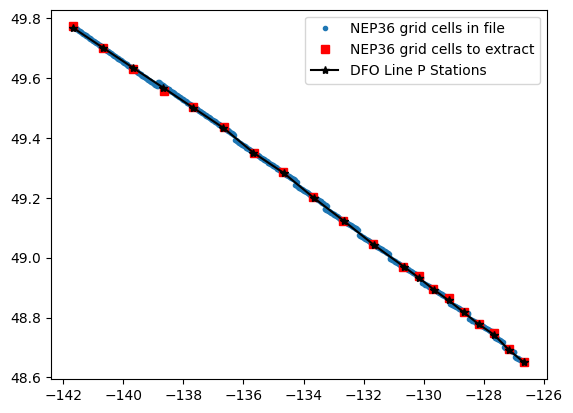

In [9]:
# Pull out nearest grid cells to each Line P station location (excluding P1-P3 (coastal stations) and P24-P26 (not available in NEP36))
LineP_station_lon = [-126.667,-127.167,-127.667,-128.167,-128.667,-129.167,-129.667,-130.167,-130.667,-131.667,-132.667,-133.667,-134.667,-135.667,-136.667,-137.667,-138.667,-139.667,-140.667,-141.667]
LineP_station_lat = [48.650,48.692,48.743,48.777,48.817,48.857,48.893,48.933,48.970,49.043,49.123,49.200,49.283,49.350,49.433,49.500,49.567,49.633,49.700,49.767]
LineP_station_list = ['P4','P5','P6','P7','P8','P9','P10','P11','P12','P13','P14','P15','P16','P17','P18','P19','P20','P21','P22','P23']

point_ind = []
for n, station in enumerate(LineP_station_lat):
    point_ind.append(np.argmin(np.abs(LineP_station_lon[n]-ds.lon).values**2+np.abs(LineP_station_lat[n]-ds.lat).values**2))

# Visualize the data along the Line and the points closest to the Stations
plt.plot(ds.lon,ds.lat,'.',label='NEP36 grid cells in file')
plt.plot(ds.lon[point_ind], ds.lat[point_ind], 'rs',label='NEP36 grid cells to extract')
plt.plot(LineP_station_lon, LineP_station_lat,'*-k',label='DFO Line P Stations')
plt.legend()

In [10]:
# Pull out data at the Line P Stations
ds_subset = ds.sel(point=ds.point[point_ind])

# Add a variable for the Line P stations - mapped from 'point'
ds_subset = ds_subset.assign_coords(station=("point",LineP_station_list))
ds_subset = ds_subset.swap_dims({'point': 'station'})

# Pull out data at the Line P Stations of interest
ds_subset = ds_subset.sel(station=stations_oi)

# And for the years of interest
ds_subset = ds_subset.where((ds_subset.time.dt.year>=np.min(years_oi))&(ds_subset.time.dt.year<=np.max(years_oi)),drop=True)

ds_subset

<xarray.Dataset> Size: 3MB
Dimensions:                (time: 300, depth: 75, station: 5)
Coordinates:
  * time                   (time) datetime64[ns] 2kB 1996-01-01 ... 2020-12-01
  * depth                  (depth) float64 600B 0.5075 1.558 ... 5.902e+03
  * station                (station) <U3 60B 'P4' 'P5' 'P6' 'P7' 'P8'
    point                  (station) int64 40B 37752 38368 39620 39601 40218
    lat                    (station) float32 20B 48.65 48.69 48.75 48.78 48.82
    lon                    (station) float32 20B -126.7 -127.2 ... -128.2 -128.7
Data variables:
    POTENTIAL_TEMPERATURE  (time, depth, station) float32 450kB 7.263 ... 0.0
    SALINITY               (time, depth, station) float32 450kB 32.09 ... 0.0
    OXYGEN_MMOL_M3         (time, depth, station) float32 450kB 298.2 ... 0.0
    TAlk                   (time, depth, station) float32 450kB 2.173e+03 ......
    DIC                    (time, depth, station) float32 450kB 2.023e+03 ......
    NO3                    (time, depth, station) float32 450kB 7.411 ... 0.0

###  4. Interpolate the NEP36 data to the vertical levels used by ref
And extract data over only the depth range of interest

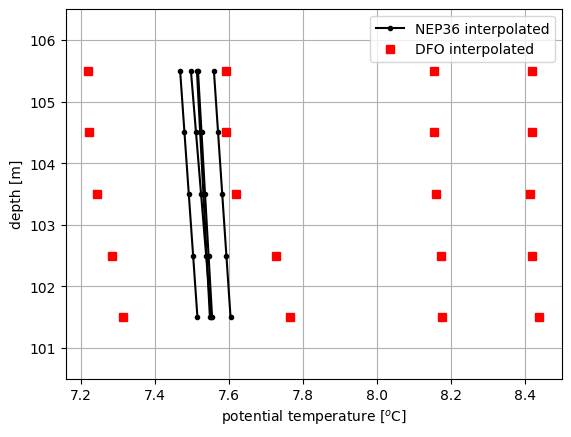

In [11]:
# Interpolate
z_grid = np.arange(0.5,2005.5,1)
ds_interp = ds_subset.interp(depth=z_grid.astype(float))

# Extract data for the depth range of interest
ds_interp = ds_interp.where((ds_interp.depth>=np.min(depths_oi))&(ds_interp.depth<=np.max(depths_oi)), drop=True)

# Visualize the result
var = vars_oi['var']
plt.plot(ds_interp[var][1,:,:],ds_interp.depth,'k.-',label='NEP36 interpolated');
plt.plot(ref_full[var][(ref_full.YEAR==1996)&(ref_full.MONTH==2)],ref_full.DEPTH[(ref_full.YEAR==1996)&(ref_full.MONTH==2)],'rs',label='DFO interpolated');
plt.ylim(np.min(depths_oi)-1, np.max(depths_oi)+1);
plt.grid()
plt.ylabel('depth [m]')
plt.xlabel('potential temperature [$^o$C]');
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys());

### 5. Extract hist and sim from the NEP36 data and train the QM model
The algorithm is trained one depth-station pair at a time. In other words, the QM model works by comparing distributions for two time series: the DFO data from a particular depth and station and the NEP36 data for the same depth and station. The adjustment for each depth-station pair is stored in an xarray, and applied to fill in missing times in sim for each depth and station.  

### 6. Validate the algorithm
This step is not done in this simple example, however a reasonable approach would be to split the data into a training and testing set, then implement something like k-fold cross validation. Ideally, this would be done for small subsets of the full dataset in the interest of time. The results of the validation would be useful when deciding what to use for the number of quantiles, or when trying out more complex QM algorithms.

### 7. Apply the algorithm to adjust sim
sim is the model output the matches the gaps in our target dataset. The result of applying the QM model to sim is called scen, for output scenario (see xsdba documentation). In this example, I ultimately combine scen (the adjusted model output) with ref (the original gappy DFO data) to make a single dataset we can take a look at.


In [12]:
# Each time through the loops represents a different station-depth pair and a different application of the QM model

# Variable we are focusing on
var = vars_oi['var']
units = vars_oi['units']

QM_list = [] # Store the QM model for each depth-station pair

temp2 = []
for j, st in enumerate(stations_oi):
    temp = []
    for k, dp in enumerate(depths_oi):

        # Extract data for the depth and station
        ds_loop = np.squeeze(ds_interp.where((ds_interp.depth==dp) & (ds_interp.station==st), drop=True)) #NEP36
        ref_loop = ref_full.loc[(ref_full.DEPTH==dp) & (ref_full.STATION_ID==st)] #DFO

        # Pull out hist (same months/years DFO cruises occurred) and sim (all other months/years)

        # List of all the months, years for which DFO cruises occurred
        DFO_date_list = sorted(list(set([(d.year, d.month) for d in ref_loop.TIME])))

        # List of all months, years for which NEP36 data is available
        NEP36_date_list = list(zip(ds_loop.time.dt.year.values,ds_loop.time.dt.month.values))

        # Find the indices of the NEP36 data that match the DFO cruise dates
        both = set(DFO_date_list).intersection(NEP36_date_list)
        indices_hist = sorted([NEP36_date_list.index(x) for x in both])

        # Move NEP36 data with these indices into hist for our training data
        hist = ds_loop[var].isel(time=indices_hist)

        # Move the rest of the NEP36 data into sim, to which we will apply the final model
        indices_sim = [i for i in range(len(ds_loop.time)) if i not in indices_hist]
        sim = ds_loop[var].isel(time=indices_sim)

        # Remove rows from ref for which no NEP36 data exists (this shouldn't really be needed in practice)
        indices_ref = sorted([DFO_date_list.index(x) for x in both])
        ref = ref_loop.iloc[indices_ref]

        # Move ref into an xarray
        ref = ref.rename(columns={'TIME': 'time'})
        ref = ref.set_index(['time']) # QM algorithm requires this
        ref = ref[var].to_xarray()
        ref = ref.assign_coords(time=hist.time.values)
        ref.attrs['units'] = units

        # Train simple Quantile Mapping
        QM = xsdba.EmpiricalQuantileMapping.train(
        ref, hist, nquantiles=nq, group="time", kind="+"
        )
        QM_list.append(QM) # Store QM models

        # Apply QM model to NEP36 data to adjust it
        scen = QM.adjust(sim, extrapolation="constant", interp="nearest")
        scen = scen.rename(var)

        full = xr.merge([scen,ref]) # Combine the adjusted data with the original DFO data

        # Move adjusted data into a list
        temp.append(full)
    temp2.append(xr.concat(temp,dim='depth'))

# Move final data into an xarray
final_scen = xr.concat(temp2,dim='station')


/var/folders/1c/yhj0kv6n5jq84j1048lny2dc0000gp/T/ipykernel_51499/3196959785.py:58: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',) The recommendation is to set join explicitly for this case.
  full = xr.merge([scen,ref]) # Combine the adjusted data with the original DFO data
/var/folders/1c/yhj0kv6n5jq84j1048lny2dc0000gp/T/ipykernel_51499/3196959785.py:58: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  full = 

### Make some figures
Look at the QM model adjustments, then look at some comparisons for the data before and after adjustment

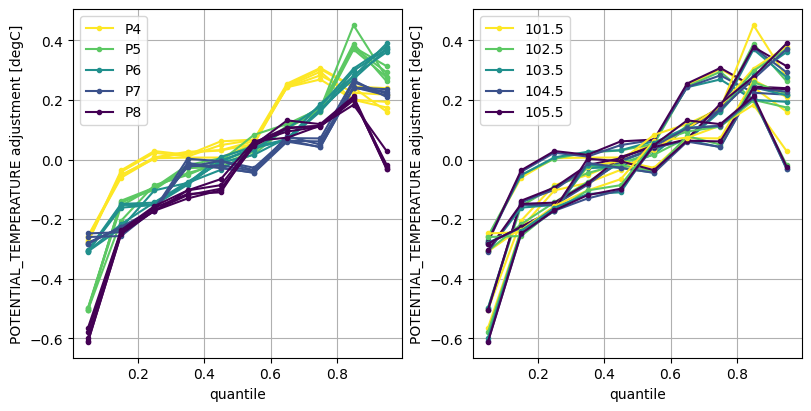

In [13]:
# QM model: adjustmens for each quantile, by depth and station

clr = plt.get_cmap('viridis_r',len(stations_oi))
custom_palette = [mpl.colors.rgb2hex(clr(i)) for i in range(clr.N)]

fig, ax = plt.subplots(1,2,figsize=(8,4),constrained_layout=True);

for i, n in enumerate(QM_list):
    s = stations_oi.index(n.ds.station)
    ax[0].plot(n.ds.quantiles,np.squeeze(n.ds.af),'.-',color=custom_palette[s],label=n.ds.station.values)

ax[0].grid()
ax[0].set_xlabel('quantile')
ax[0].set_ylabel(f'{var} adjustment [{units}]');
handles, labels = ax[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[0].legend(by_label.values(), by_label.keys());

for i, n in enumerate(QM_list):
    s = depths_oi.index(n.ds.depth)
    ax[1].plot(n.ds.quantiles,np.squeeze(n.ds.af),'.-',color=custom_palette[s],label=n.ds.depth.values)

ax[1].grid()
ax[1].set_xlabel('quantile')
ax[1].set_ylabel(f'{var} adjustment [{units}]');
handles, labels = ax[1].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax[1].legend(by_label.values(), by_label.keys());

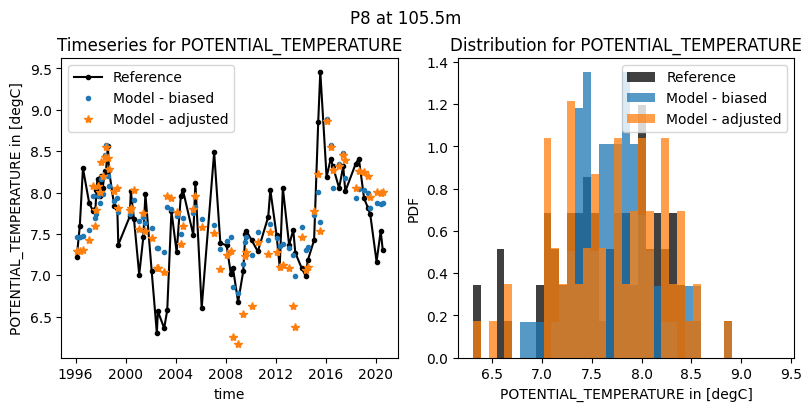

In [14]:
# Time series and Distributions

#st = 'P4'
#dp = 102.5

fig, ax = plt.subplots(1,2,figsize=(8,4),constrained_layout=True);
fig.suptitle(f'{st} at {dp}m')

ax[0].plot(ref.time, ref,'.-k',label='Reference')
ax[0].plot(hist.time, hist,'.',label='Model - biased')
ax[0].plot(ref.time, QM.adjust(hist),'*',label='Model - adjusted')
ax[0].set_title(f'Timeseries for {var}')
ax[0].set_xlabel('time')
ax[0].set_ylabel(f'{var} in [{units}]')
ax[0].legend()

bins = np.arange(np.min(ref),np.max(ref),(np.max(ref)-np.min(ref))/40)
ax[1].hist(ref,bins,density=True,alpha=0.75,color='k',label='Reference')
ax[1].hist(hist,bins,density=True,alpha=0.75,label='Model - biased')
ax[1].hist(QM.adjust(hist),bins,density=True,alpha=0.75,label='Model - adjusted')
ax[1].set_title(f'Distribution for {var}')
ax[1].set_ylabel('PDF')
ax[1].set_xlabel(f'{var} in [{units}]')
ax[1].tick_params(axis='both', which='major')
ax[1].legend()


### Next steps
There are many options to refine and improve on this simple example. Here are a few suggestions:
1. Implement QM model validation. Adjust the number of quantiles based on the results.
2. Try different depth ranges, different stations, and different variables. See how the results change to get a sense of QM performance. 
3. Investigate other statistical methods to fit and remove the seasonal cycle before applying QM. It's likely that the model bias varies seasonally. Can the model seasonal cycle be estimated using harmonic fits, then the same done for the DFO data? Could QM be applied seasonally? (Is there enough data?)
4. Refine the interpolation in depth. To use QM, data must be on the same grid. Could it be used at the model depths, and then the result interpolated? Could we fit a function to the DFO data, then use that function to extrapolate the result of the QM method over missing depths? Etc. 
5. Try more complex QM algorithms like MBCn, which can be used to adjust multiple variables simultaneously or even multiple depths / stations simultaneously.